### Utilizzo dei qdit per il graph coloring problem
- Un solo qdit per nodo;
- Ogni qdit ha $d = k_{colors}$ livelli eccitati ($\ket{0},\ket{1},...,\ket{k-1}$);
- Nessun vincolo necessario per forzare un colore per nodo: è naturale;
- Hamiltoniano meno complesso
### Implementazione concettuale
1) Ambiente come _QuTiP_ (Quantum Toolbox in Python) per simulazioni.
2) _Optimize_ di _Scipy_ per minimizzare 
l'Hamiltoniano tunando i parametri $\alpha$ e $\gamma$ del protocollo QAOA:
$$H = H_C + H_M$$
2) Hamiltoniano di costo: per ogni coppia (i,j) di noti adiacenti, termine di penalità se hanno lo stato stato:
$$H_C = \sum_{(i,j)\in E} H_{ij} = \sum_{(i,j)\in E}\sum_{c=0}^{k-1}\ket{c}_i\bra{c}\otimes\ket{c}_j\bra{c}$$
3) Hamiltoniano di mixer: qudit generalization of X gates.
$$H_M = \sum_i^{n-1}\sum_{c\neq c'=0}^{k-1}\ket{c}_i\bra{c'}+h.c.$$

In [29]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import minimize
from tqdm import tqdm

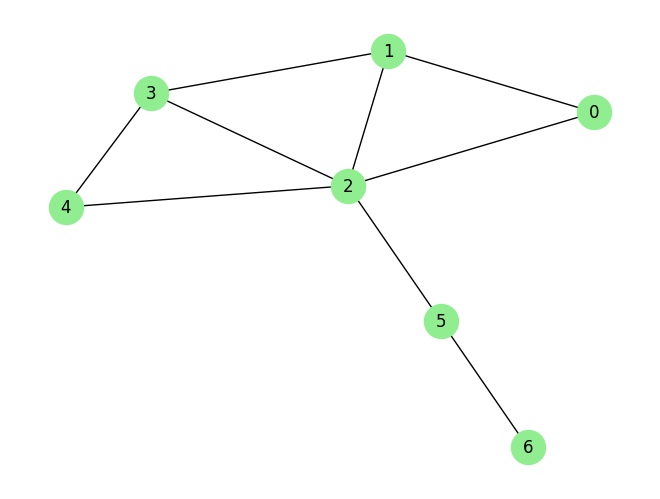

In [30]:
# Parametri
n_nodes = 7
k_colors = 3
edges = [
    (0, 1), (1, 2), (2, 0), (1, 3), (3, 2), (2, 4), (4, 3), 
    (2, 5), (5, 6) 
]
graph = nx.Graph()
graph.add_nodes_from(range(n_nodes))
graph.add_edges_from(edges)
#positions = nx.spring_layout(graph, seed=1)
#positions = nx.shell_layout(graph)
positions = nx.kamada_kawai_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color="lightgreen", edge_color="black", node_size=600)
plt.show()

In [31]:
# Trova il nodo con grado minimo
fixed_node = min(graph.degree, key=lambda x: x[1])[0]
fixed_color = 0
# Lavora con un nodo (qdit) in meno (fissato uno)
active_nodes = [i for i in range(n_nodes) if i != fixed_node]

In [32]:
# Stato iniziale: prodotto di stati uniformi
def initial_state(n_nodes, d):
    psi0 = tensor([basis(d, 0) for _ in range(n_nodes)])
    hadamard_d = (1 / np.sqrt(d)) * sum([basis(d, i) for i in range(d)])
    return tensor([hadamard_d for _ in range(n_nodes)])

In [33]:
# Hamiltoniano di costo: penalizza se due nodi hanno stesso colore
def cost_hamiltonian(n_nodes, active_nodes, d, edges, fixed_node, fixed_color):
  
    H = 0
    for (i, j) in edges:
        # Caso 1: entrambi i nodi sono attivi (non fissati)
        if i != fixed_node and j != fixed_node:
            i_idx = active_nodes.index(i)
            j_idx = active_nodes.index(j)
            for c in range(d):
                proj_i = basis(d, c) * basis(d, c).dag()
                proj_j = basis(d, c) * basis(d, c).dag()
                term = tensor([
                    proj_i if k == i_idx else
                    proj_j if k == j_idx else
                    qeye(d)
                    for k in range(n_nodes - 1)
                ])
                H += term

        # Caso 2: solo j è fisso
        elif i != fixed_node and j == fixed_node:
            i_idx = active_nodes.index(i)
            for c in range(d):
                if c == fixed_color:
                    proj_i = basis(d, c) * basis(d, c).dag()
                    term = tensor([
                        proj_i if k == i_idx else qeye(d)
                        for k in range(n_nodes - 1)
                    ])
                    H += term

        # Caso 3: solo i è fisso
        elif i == fixed_node and j != fixed_node:
            j_idx = active_nodes.index(j)
            for c in range(d):
                if c == fixed_color:
                    proj_j = basis(d, c) * basis(d, c).dag()
                    term = tensor([
                        proj_j if k == j_idx else qeye(d)
                        for k in range(n_nodes - 1)
                    ])
                    H += term

    return H

In [34]:
# Mixer Hamiltonian: somma di permutazioni fra i livelli
def mixer_hamiltonian(n_nodes, d):
    H = 0
    for i in range(n_nodes):
        for m in range(d):
            for n in range(m+1, d):
                flip = basis(d, m) * basis(d, n).dag() + basis(d, n) * basis(d, m).dag()
                op = tensor([flip if j == i else qeye(d) for j in range(n_nodes)])
                H += op
    return H

In [35]:
# Stato iniziale
psi0 = initial_state(len(active_nodes), k_colors)

# Hamiltoniani
Hc = cost_hamiltonian(n_nodes, active_nodes, k_colors, edges, fixed_node, fixed_color)
Hm = mixer_hamiltonian(len(active_nodes), k_colors)

In [36]:
# Funzione costo: aspettazione dell'H_cost sullo stato finale
loss_history = []

def qaoa_expectation(params):
    depth = len(params) // 2
    gammas = params[:depth]
    alphas = params[depth:]
    psi = psi0
    for gamma, alpha in zip(gammas, alphas):
        psi = (-1j * gamma * Hc).expm() * psi
        psi = (-1j * alpha * Hm).expm() * psi
    expectation = expect(Hc, psi)
    loss_history.append(expectation)  # salva loss
    return expectation


In [37]:
# Preparazione della barra di caricamento per l'ottimizzazione (con callback da "minimize")
n_steps = 100  # massimo numero di iterazioni dell’ottimizzatore
pbar = tqdm(total=n_steps, desc="Training Progress")
def optimization_callback(xk):
    pbar.update(1)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
# Inizializzazione random
depth = 1
init_params = np.full(2 * depth, 0.5)

# Ottimizzazione
result = minimize(
    qaoa_expectation,
    init_params,
    method='COBYLA',
    callback=optimization_callback,
    options={'maxiter': n_steps}
)
pbar.close()
opt_params = result.x
opt_expectation = result.fun
print("Migliori parametri trovati:", opt_params)
print("Valore minimo atteso H_cost:", opt_expectation)


Training Progress: 101it [01:07,  1.51it/s]                         

Migliori parametri trovati: [0.73981574 1.8518595 ]
Valore minimo atteso H_cost: 1.5874083637024352


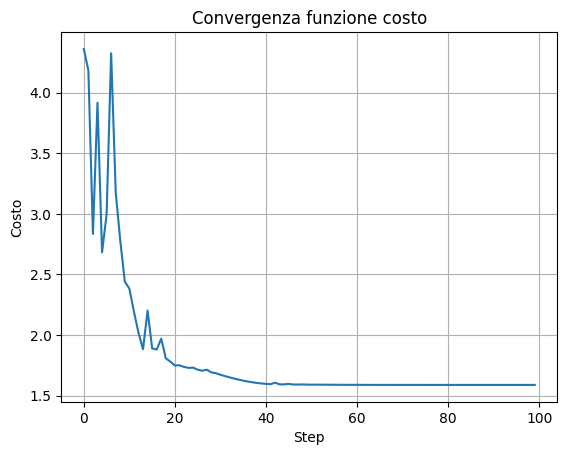

In [39]:
# Plot convergenza funzione costo
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("Costo")
plt.title("Convergenza funzione costo")
plt.grid(True)
plt.show()

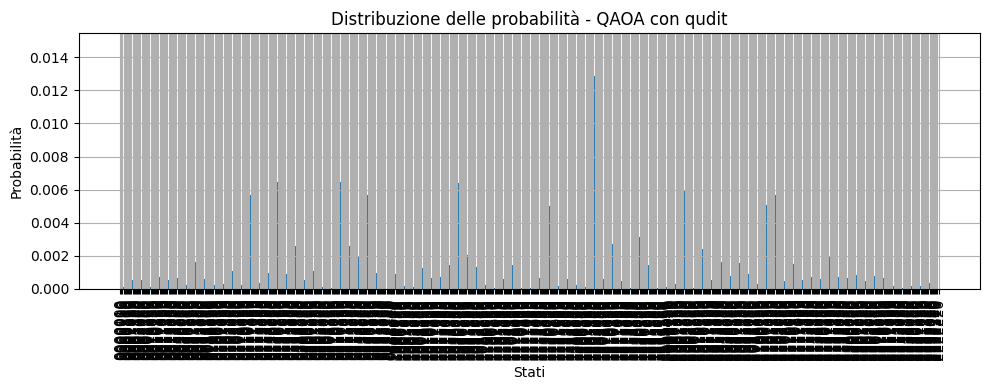

In [40]:
# Stato finale con parametri ottimizzati
final_state = psi0
for gamma, alpha in zip(opt_params[:depth], opt_params[depth:]):
    final_state = (-1j * gamma * Hc).expm() * final_state
    final_state = (-1j * alpha * Hm).expm() * final_state

# Probabilità finali
probs = np.abs(final_state.full().flatten())**2

# digitstring completa (include nodo fissato)
def insert_fixed_digitstring(raw_digitstring, fixed_node, fixed_color, n_nodes):
    chunks = []
    active_index = 0
    for node in range(n_nodes):
        if node == fixed_node:
            chunks.append(str(fixed_color))
        else:
            chunks.append(str(raw_digitstring[active_index]))
            active_index += 1
    return ''.join(chunks)

digitstrings = []
for i in range(k_colors**len(active_nodes)):
    raw = np.base_repr(i, base=k_colors).zfill(len(active_nodes))
    full = insert_fixed_digitstring(raw, fixed_node, fixed_color, n_nodes)
    digitstrings.append(full)

# Istogramma
plt.figure(figsize=(10, 4))
plt.bar(digitstrings, probs)
plt.xticks(rotation=90)
plt.xlabel("Stati")
plt.ylabel("Probabilità")
plt.title("Distribuzione delle probabilità - QAOA con qudit")
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
# Decodifica e analisi delle stringhe di output
def decode_qudit_string(s):
    """Trasforma una stringa tipo '012' in un dizionario nodo → colore"""
    return {node: int(color) for node, color in enumerate(s)}

def is_valid_coloring_qudit(assignment, edges):
    """Controlla che due nodi adiacenti non abbiano lo stesso colore"""
    for u, v in edges:
        if assignment[u] == assignment[v]:
            return False
    return True

threshold = max(probs) - 0.0001
print("Bitstring | Assegnamento | Valido | Probabilità")
print("-" * 50)

valid_count = 0
best_assignment = None

for i, p in enumerate(probs):
    if p > threshold:
        s = digitstrings[i]
        assignment = decode_qudit_string(s)
        valid = is_valid_coloring_qudit(assignment, edges)
        print(f"{s} | {assignment} | {valid} | {p:.4f}")
        if valid:
            valid_count += 1
            best_assignment = assignment

if valid_count > 0:
    print(f"Il numero cromatico del grafo è {k_colors} e si può colorare in {valid_count} modi diversi")
else:
    print(f"\nNessuna colorazione valida trovata con {k_colors} colori.")


Bitstring | Assegnamento | Valido | Probabilità
--------------------------------------------------
0120110 | {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 1, 6: 0} | True | 0.0147
0210220 | {0: 0, 1: 2, 2: 1, 3: 0, 4: 2, 5: 2, 6: 0} | True | 0.0147
1021010 | {0: 1, 1: 0, 2: 2, 3: 1, 4: 0, 5: 1, 6: 0} | True | 0.0147
2012020 | {0: 2, 1: 0, 2: 1, 3: 2, 4: 0, 5: 2, 6: 0} | True | 0.0147
Il numero cromatico del grafo è 3 e si può colorare in 4 modi diversi


In [42]:
#Output: numero cromatico
if valid_count > 0:
    print(f"Il numero cromatico del grafo è {k_colors} e si può colorare in {valid_count} modi diversi")
else:
    print(f"\nNessuna colorazione valida trovata con {k_colors} colori.")


Il numero cromatico del grafo è 3 e si può colorare in 4 modi diversi


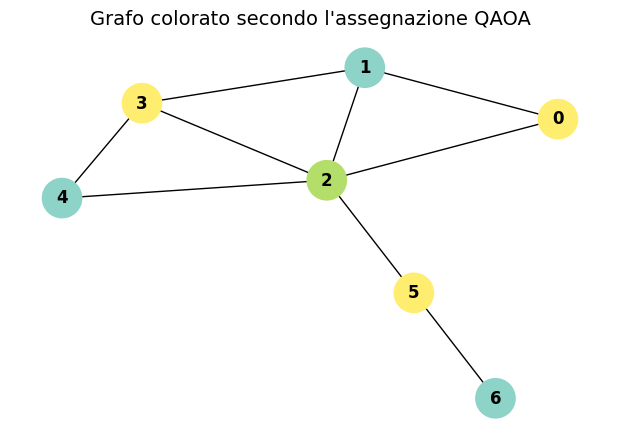

In [43]:
# Visualizza grafo colorato
def plot_colored_graph(graph, assignment, positions, cmap=plt.cm.Set3):
    node_colors = [assignment[n] for n in graph.nodes]
    unique_colors = sorted(set(node_colors))
    
    n_colors = len(unique_colors)
    color_list = [cmap(i / max(1, n_colors - 1)) for i in range(n_colors)]
    color_map = {c: color_list[i] for i, c in enumerate(unique_colors)}
    final_colors = [color_map[c] for c in node_colors]

    plt.figure(figsize=(6, 4))
    nx.draw(
        graph,
        pos=positions,
        with_labels=True,
        node_color=final_colors,
        edge_color="black",
        node_size=800,
        font_color="black",
        font_weight="bold"
    )
    plt.title("Grafo colorato secondo l'assegnazione QAOA", fontsize=14)
    plt.axis('off')
    plt.show()

if best_assignment:
    plot_colored_graph(graph, best_assignment, positions)